# Spectrum to SMILES Pair Encoding (SPE) Vector Translation

This notebook uses SmilesPE in order to tokenize and later vectorize the SMILES. This process was explored due to SMILES strings generation leading to complications with highly overfitting to carbons and oxygen atoms. While traditional character-level tokenization of SMILES tends to overemphasize common atomic elements, SmilesPE's approach treats chemical substructures as meaningful tokens, providing a more chemically-aware representation.

This notebook explores molecule classification by converting mass spectrometry data into learned molecular embeddings that can be used for similarity searching and compound identification. The approach uses a deep learning architecture combining CNNs and Bidirectional LSTMs to create a bridge between spectral data and molecular representa

### SMILES tokenization and vectorization

This code block is largely inspired by the example notebooks SPEC2Vec.ipynb and train_SPE.ipynb in the SmilesPE GitHub (https://github.com/XinhaoLi74/SmilesPE/tree/master)

In [ ]:
import os
import codecs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout, Reshape, LSTM, Bidirectional
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

from SmilesPE.learner import learn_SPE
from SmilesPE.spe2vec import SPE2Vec
from SmilesPE.tokenizer import SPE_Tokenizer
from gensim.models import Word2Vec

In [10]:
# load data
file_name = "gc_deepsmiles.csv"
df = pd.read_csv(file_name)

df.head()

,SMILES,DeepSMILES,Spectrum
0,OCc1ccccc1,OCcccccc6,49:2.9 50:20 51:50.5 52:10.1 53:8.3 54:2.1 60:...
1,CCCCCCCCC=CCCCCCCCCO,CCCCCCCCC=CCCCCCCCCO,45:3.9 51:1.4 53:13.7 54:99.99 55:55.2 56:72.8...
2,Cc1ccc(S(=O)(=O)NC2CCCCC2)cc1,CccccS=O)=O)NCCCCCC6))))))))cc6,43:5.7 44:2.7 51:3.8 53:1.9 54:6.5 55:6 62:4.1...
3,Cc1ccc(S(N)(=O)=O)cc1,CccccSN)=O)=O))cc6,50:3.6 51:6.6 52:2.4 53:1.9 61:3 62:9.6 63:2.6...
4,CCNS(=O)(=O)c1ccccc1C,CCNS=O)=O)cccccc6C,44:48.8 45:1.6 50:3.3 51:6.7 52:2.2 53:1.7 57:...


In [12]:
# extra the smiles and spectrum column
SMILES = df['SMILES'].tolist()
Spectra = df['Spectrum'].tolist()
print('Number of SMILES:', len(SMILES))

# training
output_file = "SPE_gc_deepsmiles_filtered.txt"
output = codecs.open(output_file, 'w')

# learn spe
learn_SPE(SMILES, output, 10000, min_frequency=500, augmentation=0, verbose=True, total_symbols=True)
output.close()
print(f"SPE vocabulary saved to {output_file}")

# train the Word2Vec model
spe_vob = codecs.open(output_file, 'r')
spe_tokenizer = SPE_Tokenizer(spe_vob)
tokenized_smiles = [spe_tokenizer.tokenize(smi) for smi in SMILES]

# train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_smiles, vector_size=100, window=5, min_count=1, workers=4)
word2vec_model_path = "spe_model.bin"
word2vec_model.save(word2vec_model_path)
print(f"Word2Vec model saved to {word2vec_model_path}")

# update SPE2Vec class to use Gensim 4.0.0 attributes
class SPE2VecUpdated(SPE2Vec):
    def __init__(self, model_path, tokenizer):
        self.model = Word2Vec.load(model_path)
        self.tokenizer = tokenizer
        self.token_keys = set(self.model.wv.key_to_index.keys())

# load the trained SPE model
spe2vec_model = SPE2VecUpdated(word2vec_model_path, spe_tokenizer)

# load csv
file_name = "gc_deepsmiles.csv"
df = pd.read_csv(file_name)

# extract the SMILES and Spectrum columns
SMILES = df['SMILES'].tolist()
Spectra = df['Spectrum'].tolist()

# tokenize and generate vectors for the SMILES strings
smiles_vectors = []
valid_smiles = []
valid_spectra = []
for smi, spectrum in zip(SMILES, Spectra):
    smivec = spe2vec_model.smiles2vec(smi, mode='average')  # You can choose other modes like 'sum', 'avg_pool', 'sum_pool'
    if smivec.shape == (100,):  # Ensure the vector has the correct shape
        smiles_vectors.append(smivec)
        valid_smiles.append(smi)
        valid_spectra.append(spectrum)
    else:
        print(f"Invalid vector shape for SMILES: {smi}, Vector shape: {smivec.shape}")

smiles_vectors_df = pd.DataFrame(smiles_vectors, index=valid_smiles)
smiles_vectors_df['Spectrum'] = valid_spectra

print(smiles_vectors_df.head())

# saving the vectors to a new CSV file
output_file = "gc_vector.csv"
smiles_vectors_df.to_csv(output_file)

smiles_vectors_df.head()

Number of SMILES: 18772
Counting SMILES...
9088 unique Canonical SMILES
Gettting Pair Statistics


Number of unique characters & Reducing number of merge operations by: 66
Unique characters: {'[CH2-]', 'N', '5', '[SiH3]', '=', '[O-]', '[Sn]', '[H]', '[Ni+2]', ')', '[CH3]', '.', 'Br', '[Zn+2]', '[Cu+2]', '[CH2+]', 'B', '6', 'C', 'O', '(', '1', '4', '[N-]', '[N+]', '[F-]', 'Cl', '[SiH]', 'F', '[SiH2]', 'P', '[S+]', '[Sn+2]', '3', '[Al+3]', '[Br-]', '[CH2]', '[Si]', '[Hg]', '[Se]', '[Ge]', '#', '[I-]', '[nH]', '[Co+2]', 'n', '[n+]', '-', 'S', '[C-]', '[Na+]', '[S-]', '[Cl-]', '[CH]', 's', '[c]', '[Pt+2]', '2', 'o', '7', 'I', '[Pd+2]', '[Sn+]', '[Co+3]', 'c', '[PH]'}
pair 0: C C -> CC (frequency 58134)
pair 1: c c -> cc (frequency 34101)
pair 2: O ) -> O) (frequency 19588)
pair 3: C ( -> C( (frequency 18485)
pair 4: C ) -> C) (frequency 15261)
pair 5: c 1 -> c1 (frequency 14618)
pair 6: CC CC -> CCCC (frequency 13035)
pair 7: = O) -> =O) (frequency 10568)
pair 8: ( C) -> (C) (frequency 8668)
pair 9: c1 cc -> c1cc (frequency 7492)
pair 10: C( =O) -> C(=O) (frequency 6138)
pair 11: C 1 ->

SPE vocabulary saved to SPE_gc_deepsmiles_filtered.txt
Word2Vec model saved to spe_model.bin
Invalid vector shape for SMILES: CCCCCCCCC=CCCCCCCCCO, Vector shape: ()
Invalid vector shape for SMILES: CCC1=NCC(C)N1, Vector shape: ()
Invalid vector shape for SMILES: CC1=NCC(C)N1, Vector shape: ()
Invalid vector shape for SMILES: CCCCCCCCCCCCCCCCCC1=NCCN1, Vector shape: ()
Invalid vector shape for SMILES: CCC1=NCCN1, Vector shape: ()
Invalid vector shape for SMILES: CC1=NCCN1, Vector shape: ()
Invalid vector shape for SMILES: ClC1C(Cl)C(Cl)C(Cl)C(Cl)C1Cl, Vector shape: ()
Invalid vector shape for SMILES: CCCCC(C(=O)OCC)C(=O)OCC, Vector shape: ()
Invalid vector shape for SMILES: COC(=O)c1ccc(N)cc1, Vector shape: ()
Invalid vector shape for SMILES: CCOC(=O)c1ccc(N)cc1, Vector shape: ()
Invalid vector shape for SMILES: O=C(O)c1ccccc1, Vector shape: ()
Invalid vector shape for SMILES: CC(=O)Oc1ccccc1C(=O)O, Vector shape: ()
Invalid vector shape for SMILES: CCOc1ccc(N=C(C)O)cc1, Vector shape: ()

/opt/anaconda3/envs/msse-python/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/msse-python/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Invalid vector shape for SMILES: CCC(C)C, Vector shape: ()
Invalid vector shape for SMILES: CC1CCCCC1, Vector shape: ()
Invalid vector shape for SMILES: CCOC(=O)C(O)c1ccccc1, Vector shape: ()
Invalid vector shape for SMILES: CCC(C)C, Vector shape: ()
Invalid vector shape for SMILES: CC1CCCCC1, Vector shape: ()
Invalid vector shape for SMILES: CCOC(=O)C(O)c1ccccc1, Vector shape: ()
Invalid vector shape for SMILES: COc1cc(O)c(C(C)=O)c(OC)c1, Vector shape: ()
Invalid vector shape for SMILES: COc1ccc(C(C)=O)c(OC)c1, Vector shape: ()
Invalid vector shape for SMILES: COc1cccc(O)c1C(C)=O, Vector shape: ()
Invalid vector shape for SMILES: COc1ccc(O)c(C(C)=O)c1, Vector shape: ()
Invalid vector shape for SMILES: COc1ccc(C(C)=O)c(O)c1, Vector shape: ()
Invalid vector shape for SMILES: C=C(C)C1CCC2(C)CCCC(C)(O)C2C1, Vector shape: ()
Invalid vector shape for SMILES: C=C(C)C1CCC2(C)CCC=C(C)C2C1, Vector shape: ()
Invalid vector shape for SMILES: CCOC(=O)CCC(C)=O, Vector shape: ()
Invalid vector shape

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,Spectrum
OCc1ccccc1,-0.307151,0.018621,-0.082626,-0.253801,0.032901,-0.138210,0.544152,0.282515,0.253974,-0.082405,...,0.011114,-0.193921,-0.056644,0.212461,0.092656,-0.358379,-0.231521,-0.049787,-0.493109,49:2.9 50:20 51:50.5 52:10.1 53:8.3 54:2.1 60:...
Cc1ccc(S(=O)(=O)NC2CCCCC2)cc1,-0.177327,-0.306524,-0.226212,0.014968,-0.455498,-0.030700,-0.055095,0.004926,0.241518,0.197861,...,-0.020129,0.219411,0.036165,-0.211341,0.060579,-0.370114,0.055311,-0.205679,0.493834,43:5.7 44:2.7 51:3.8 53:1.9 54:6.5 55:6 62:4.1...
Cc1ccc(S(N)(=O)=O)cc1,-0.154256,-0.687518,-0.333979,-0.056753,-0.449302,0.161325,0.182068,-0.147700,0.213896,0.227148,...,-0.168342,0.120210,0.002363,-0.221255,-0.022829,-0.543525,0.009204,-0.206029,0.638110,50:3.6 51:6.6 52:2.4 53:1.9 61:3 62:9.6 63:2.6...
CCNS(=O)(=O)c1ccccc1C,-0.252157,-0.462095,-0.248671,-0.042580,-0.646134,-0.102799,-0.112600,-0.002285,0.177395,0.129769,...,0.041634,0.206261,0.020480,-0.187839,0.110315,-0.488460,0.036716,-0.179740,0.537847,44:48.8 45:1.6 50:3.3 51:6.7 52:2.2 53:1.7 57:...
CCNS(=O)(=O)c1ccc(C)cc1,-0.453995,-0.603564,-0.187516,0.023786,-0.987616,-0.107839,-0.115024,-0.102633,0.231038,0.146464,...,0.083984,0.179880,-0.021260,-0.163714,0.197496,-0.562799,-0.113770,-0.227558,0.535225,50:2.6 51:5.9 52:1.7 53:1.3 61:2 62:8.5 63:2.9...


## Spectra Preprocessing

The function below takes a mass spectrometry string as input and preprocesses it into a 2D representation suitable for the 2D CNN. 

1. Initializes a 2D zero matrix with dimensions `mz_bins` and `intensity_bins`.
2. Converts the spectrum string to a pandas DataFrame containing m/z values and intensities.
3. Normalizes the intensities by dividing them by the maximum intensity.
4. Filters out peaks with intensities below a certain threshold (`noise_threshold`).
5. Scales the m/z values to fit within the `mz_bins` range.
6. Fills the 2D matrix with 1s based on the scaled m/z values and intensities.

In [25]:
def preprocess_ms_to_2d(spectrum_string, mz_bins=200, intensity_bins=100, noise_threshold=0.01):
    spectrum = np.zeros((mz_bins, intensity_bins))
    
    df = pd.DataFrame([peak.split(':') for peak in spectrum_string.split()], columns=['m/z', 'intensity'])
    df = df.astype(float)
    max_intensity = df['intensity'].max()
    if max_intensity > 0:
        df['intensity'] /= max_intensity
    df = df[df['intensity'] >= noise_threshold]
    mz_values = df['m/z'].values
    intensities = df['intensity'].values
    mz_min, mz_max = mz_values.min(), mz_values.max()
    if mz_max != mz_min:
        mz_scaled = np.round((mz_values - mz_min) / (mz_max - mz_min) * (mz_bins - 1)).astype(int)
        for mz, intensity in zip(mz_scaled, intensities):
            intensity_scaled = min(int(intensity * (intensity_bins - 1)), intensity_bins - 1)
            spectrum[mz, :intensity_scaled + 1] = 1
    
    return spectrum


In [ ]:
# for visualization used later
def plot_spectrum_and_heatmap(spectrum_string, mz_bins=200, intensity_bins=100):
    """
    Plots the original spectrum and its 2D heatmap representation.
    """
    spectrum_2d = preprocess_ms_to_2d(spectrum_string, mz_bins, intensity_bins)

    # Plot original spectrum
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    mz_values, intensities = zip(*[map(float, peak.split(':')) for peak in spectrum_string.split()])
    plt.bar(mz_values, intensities, width=1.0, color='blue', alpha=0.7)
    plt.title("Original Spectrum")
    plt.xlabel("m/z")
    plt.ylabel("Intensity (Normalized)")

    # Plot 2D heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(spectrum_2d.T, aspect='auto', origin='lower', cmap='hot', extent=[0, mz_bins, 0, intensity_bins])
    plt.title("2D Heatmap Representation")
    plt.xlabel("m/z Bins")
    plt.ylabel("Intensity Bins")
    plt.colorbar(label="Presence")
    plt.tight_layout()
    plt.show()


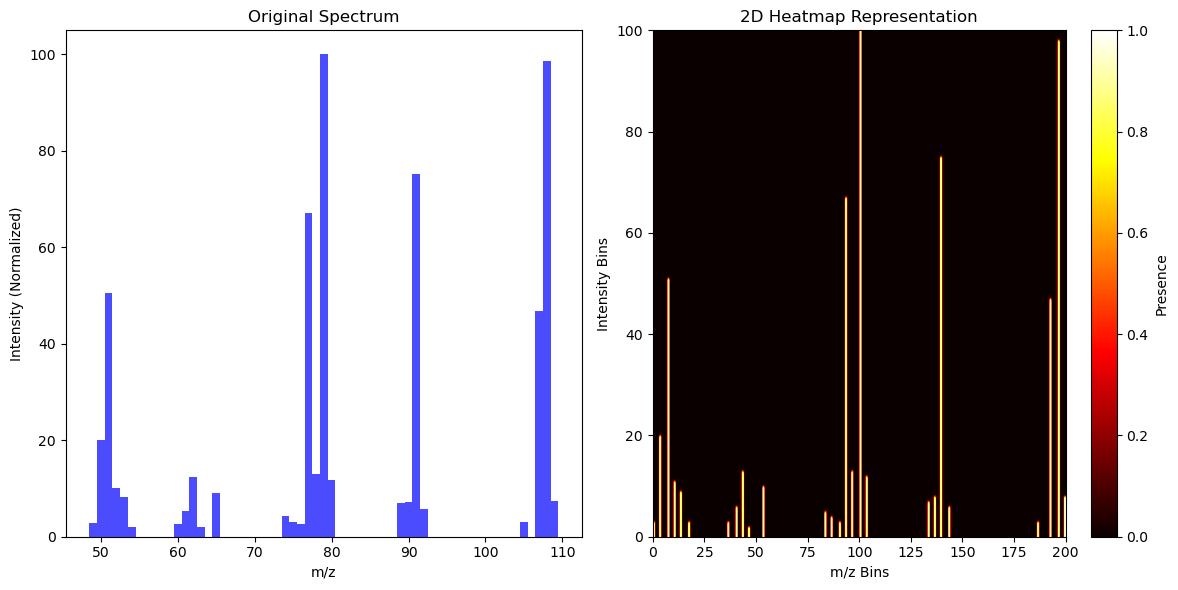

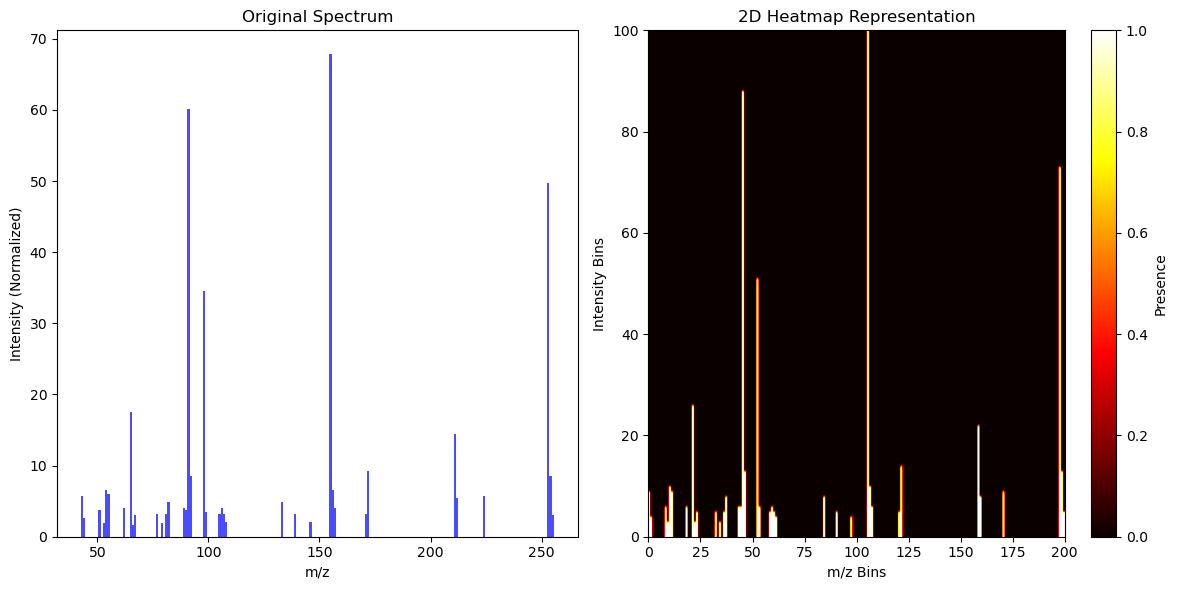

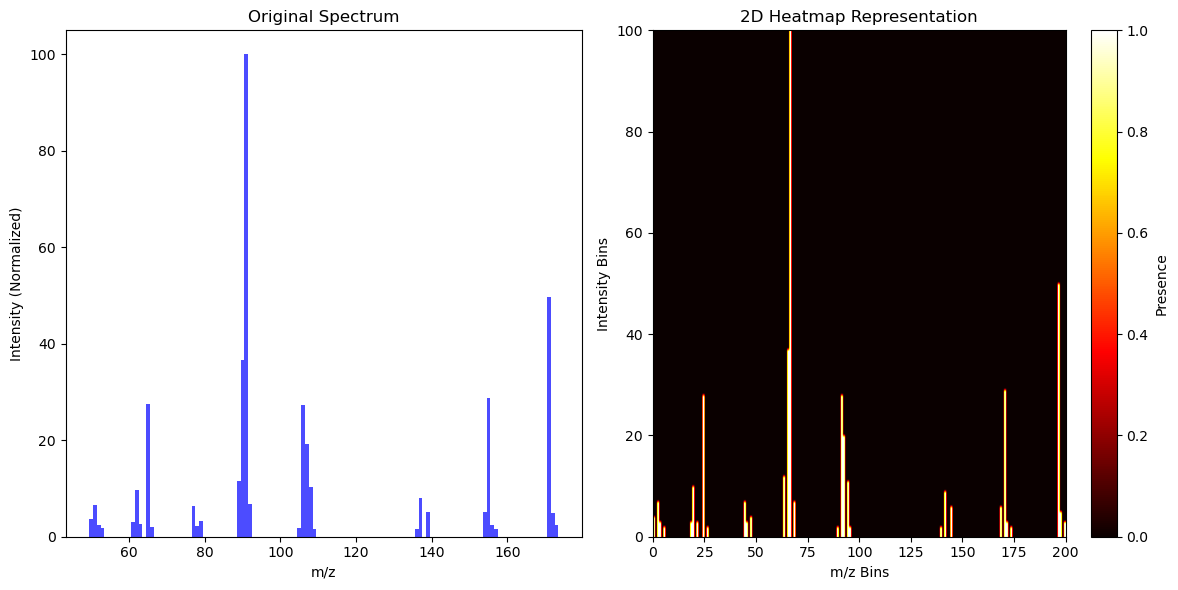

In [28]:
# Load dataset
df = pd.read_csv('gc_vector.csv')

# Preprocess spectra and visualize a few examples
df['Processed_Spectrum'] = df['Spectrum'].apply(preprocess_ms_to_2d)

# Plot a few examples
test_spectra = df['Spectrum'].dropna().head(3)
for i, spectrum in enumerate(test_spectra):
    plot_spectrum_and_heatmap(spectrum)


In [29]:
# Convert processed spectra into arrays
spectra_array = np.stack(df['Processed_Spectrum'].values)
spectra_array = np.expand_dims(spectra_array, axis=-1)

# Extract vector data
vector_columns = [str(i) for i in range(100)]
vector_array = df[vector_columns].values.astype(np.float32)

# Print shapes for verification
print("Spectra Array Shape:", spectra_array.shape)
print("Vector Array Shape:", vector_array.shape)


Spectra Array Shape: (13496, 200, 100, 1)
Vector Array Shape: (13496, 100)


Spectra Array Shape: 
* 13496 Spectrums 
* 200: # of bins along the m/z (mass-to-charge ratio) axis in the 2D representation.
* 100: # of bins along the intensity axis in the 2D representation.

Vector Array Shape:
* 13496: The number of samples (matching the spectra array).
* 100: The dimensionality of the target vector for each sample (Spe Vector)

### Splitting for Test/Train & Tensorflow Dataset Preperation

In [30]:
# Split data
X_train_full, X_test, y_train_full, y_test = train_test_split(
    spectra_array, vector_array, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42
)

# Print split sizes
print("Training Data Shape:", X_train.shape, y_train.shape)
print("Validation Data Shape:", X_val.shape, y_val.shape)
print("Testing Data Shape:", X_test.shape, y_test.shape)


Training Data Shape: (9716, 200, 100, 1) (9716, 100)
Validation Data Shape: (1080, 200, 100, 1) (1080, 100)
Testing Data Shape: (2700, 200, 100, 1) (2700, 100)


In [31]:
# Prepare datasets
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

# Print data pipeline example
for x_batch, y_batch in train_data.take(1):
    print("Batch X Shape:", x_batch.shape)
    print("Batch Y Shape:", y_batch.shape)


Batch X Shape: (32, 200, 100, 1)
Batch Y Shape: (32, 100)


2024-12-13 17:18:52.577315: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## CNN + LSTM Encoder Model

In [32]:
def lstm_encoder(input_shape, latent_dim=128, dropout_rate=0.3):
    encoder_input = Input(shape=input_shape, name="encoder_input")

    # Convolutional layers for feature extraction
    x = Conv2D(32, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(encoder_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(64, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(dropout_rate)(x)

    # Flatten and reshape for LSTM input
    x = Flatten()(x)
    x = Dense(latent_dim, activation="relu", kernel_regularizer=l2(1e-4))(x)
    x = Reshape((-1, latent_dim))(x)  # Reshape into sequences

    # Bidirectional LSTM for sequence encoding
    x = Bidirectional(LSTM(latent_dim, return_sequences=False, dropout=dropout_rate))(x)

    # Latent representation
    encoder_features = Dense(latent_dim, activation="relu", name="encoder_features", kernel_regularizer=l2(1e-4))(x)

    return Model(encoder_input, encoder_features, name="lstm_encoder")


## Decoder Model

In [35]:
def build_decoder(vector_dim, latent_dim=128, dropout_rate=0.3):
    
    encoder_features = Input(shape=(latent_dim,), name="encoder_features_input")

    x = Dense(256, activation="relu", kernel_regularizer=l2(1e-4))(encoder_features)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(128, activation="relu", kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    # Output layer
    x = Dense(vector_dim, activation="linear", kernel_regularizer=l2(1e-4), name="vector_output")(x)

    return Model(encoder_features, x, name="decoder")


## Combine Encoder + Decoder

In [36]:
input_shape = (200, 100, 1) 
latent_dim = 128  # dim of latent representation
vector_dim = 100  # dim of the target vectors

# instantiate encoder and decoder
encoder = lstm_encoder(input_shape, latent_dim)
decoder = build_decoder(vector_dim, latent_dim)

# combine to single model
encoder_input = Input(shape=input_shape, name="encoder_input")
encoder_features = encoder(encoder_input)
decoder_output = decoder(encoder_features)
model = Model(encoder_input, decoder_output, name="encoder_decoder_model")

# print model summary
model.summary()


Model: "encoder_decoder_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 200, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_encoder (Functional)       │ (None, 128)            │    10,555,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 100)            │        80,356 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,635,748 (40.57 MB)

 Trainable params: 10,634,788 (40.57 MB)

 Non-trainable params: 960 (3.75 KB)

In [37]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="mean_squared_error",
    metrics=["mean_absolute_error"]
)


In [41]:
# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

# After training, save predictions for the test dataset
import pandas as pd
import os

# Ensure the output directory exists
output_dir = "predictions"
os.makedirs(output_dir, exist_ok=True)

# Generate predictions
predictions = model.predict(test_data)
actuals = np.vstack([y.numpy() for _, y in test_data])  # Extract actual values from test dataset

# Save predictions to a CSV file
df = pd.DataFrame({
    "Actuals": [list(vec) for vec in actuals],
    "Predictions": [list(vec) for vec in predictions]
})
csv_path = os.path.join(output_dir, "final_predictions.csv")
df.to_csv(csv_path, index=False)

print(f"Saved final predictions to {csv_path}")


KeyboardInterrupt: 

## Results

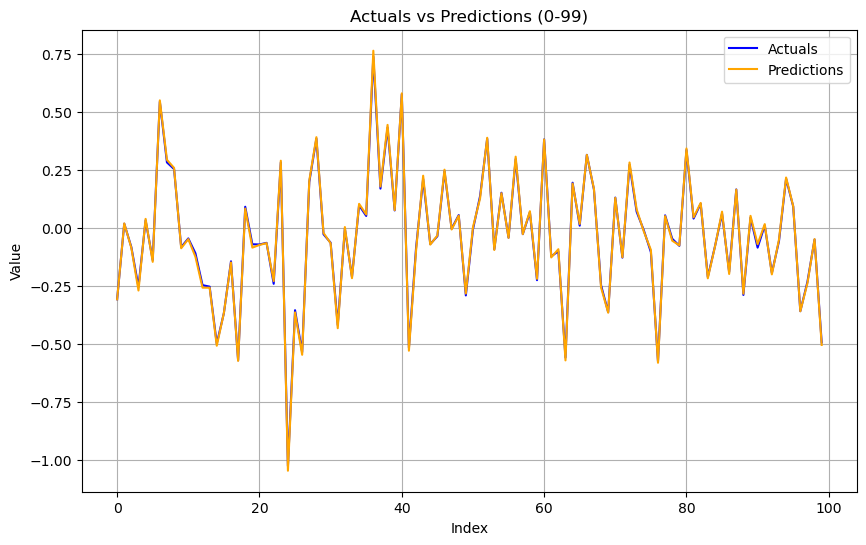

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("predictions/final_predictions.csv")

data['Actuals'] = data['Actuals'].apply(lambda x: np.array(eval(x)))
data['Predictions'] = data['Predictions'].apply(lambda x: np.array(eval(x)))

# give an index to check
actuals = data['Actuals'].values[64]
predictions = data['Predictions'].values[64]

plt.figure(figsize=(10, 6))
plt.plot(range(len(actuals)), actuals, label="Actuals", color="blue")
plt.plot(range(len(predictions)), predictions, label="Predictions", color="orange")
plt.title("Actuals vs Predictions (0-99)")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


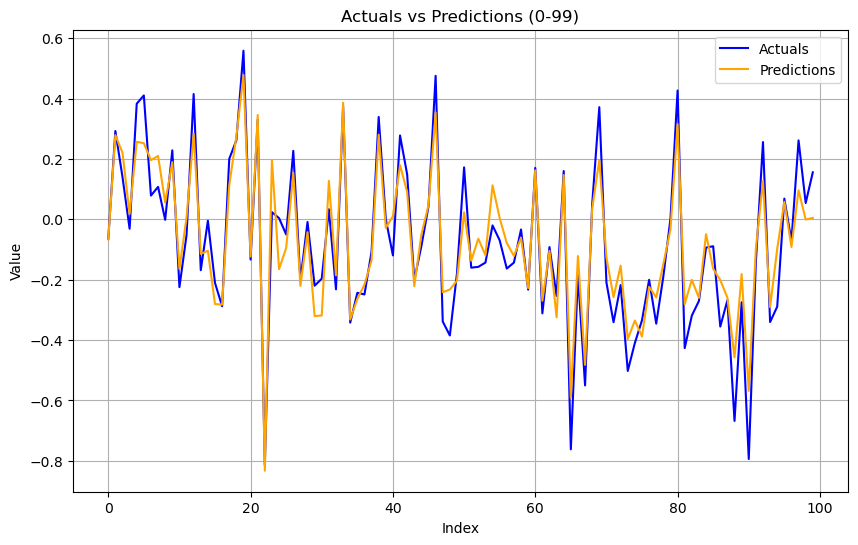

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("predictions/final_predictions.csv")

data['Actuals'] = data['Actuals'].apply(lambda x: np.array(eval(x)))
data['Predictions'] = data['Predictions'].apply(lambda x: np.array(eval(x)))

# give an index to check
actuals = data['Actuals'].values[1000]
predictions = data['Predictions'].values[1000]

plt.figure(figsize=(10, 6))
plt.plot(range(len(actuals)), actuals, label="Actuals", color="blue")
plt.plot(range(len(predictions)), predictions, label="Predictions", color="orange")
plt.title("Actuals vs Predictions (0-99)")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()
